This notebook illustrates the most concise yet the slowest nonlinear $R_2^*$ fitting function I have ever written

In [1]:
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import xarray as xr
import pandas as pd
import nibabel as nib
from scipy.optimize import least_squares
from good_bad_questionable.mapping import nonlinear_fit

# Data loading
**Open question:** what open data can we use?

In [44]:
json_path = '/home/renat/soft/moc_session19/good-bad-questionable/data/sub-01_FLASH.json'
with open(json_path) as f:
    te = json.load(f)['EchoTime']

Mask can (and should) be used to limit the scope of fitting

In [45]:
mask_path = '/home/renat/soft/moc_session19/good-bad-questionable/data/sub-01_mask.nii.gz'
mask = nib.load(mask_path).get_fdata().astype(bool)

In [46]:
data_path = '/home/renat/soft/moc_session19/good-bad-questionable/data/sub-01_part-mag_FLASH.nii.gz'
img = nib.load(data_path)
print(f'data shape: {img.shape}')
print(f'axis labels: {nib.aff2axcodes(img.affine)}')

data shape: (168, 224, 160, 5)
axis labels: ('L', 'P', 'S')


The secret to concise application: xarray and its integration with pandas

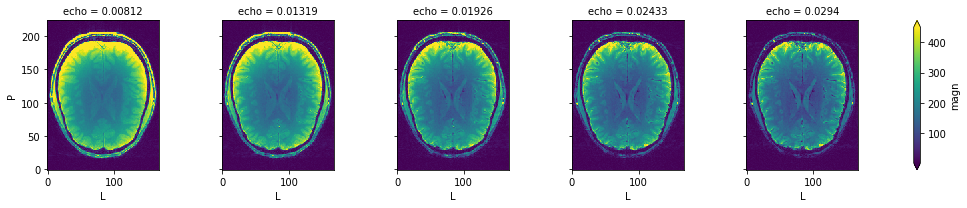

In [47]:
data_array = xr.DataArray(data=img.get_fdata(), dims=nib.aff2axcodes(img.affine) + ('echo',), coords={'echo': te})
data_array.name = 'magn' # needed for xr.DataArray -> pd.DataFrame conversion
data_array.isel(S=80).plot(x='L', y='P', col='echo', robust=True, subplot_kws={'aspect':1})

For performance sake let's limit the fitting to a square of $40\times 40$ voxels

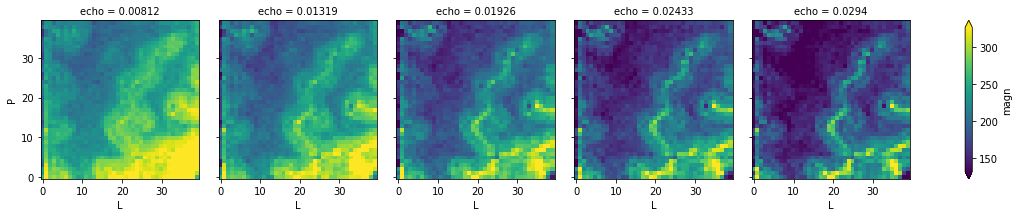

In [54]:
subvolume = data_array.isel(S=110, L=range(84,124), P=range(70,110))
subvolume.plot(x='L', y='P', col='echo', robust=True, subplot_kws={'aspect':1})

Let's define the signal model

In [55]:
def model(p, t):
    return p[0] * np.exp(-p[1] * t)

In [56]:
ds_fit, dtime = nonlinear_fit(subvolume, model, p0=[500, 50], dim_fit='echo', p_names = ['s0', 'r2_star'])

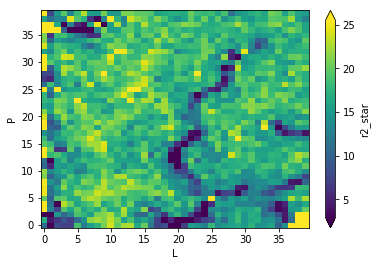

In [57]:
ds_fit.r2_star.plot(x='L', y='P', robust=True)

A crude lowest estimate for the time needed to fit the full brain:

In [58]:
time_estimate = (mask.sum() / ds_fit.r2_star.size) * dtime
print(f'estimate to fit full brain: {time_estimate / 3600:.2g} h')

estimate to fit full brain: 38 h
